
# Deep Learning Homework 6 (Spring 2023)

This code is provided for Deep Learning class (601.482/682) Homework 6. For ease of implementation, we recommend working entire in Google Colaboratory.

@Copyright Cong Gao, the Johns Hopkins University, cgao11@jhu.edu. Modifications made by Hongtao Wu, Suzanna Sia, Hao Ding, Keith Harrigian, and Yiqing Shen.


### Imports

In [1]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Mounting Failed.


In [3]:
## Standard Library
import os
import json

## External Libraries
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import Dataset, DataLoader
from skimage import io
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Problem 1: Unsupervised Pre-training

### Training Hyperparameters

These are recommended hyperparameters - please feel free to use what works for you. Batch size can be changed if it does not match your memory, please state your batch step_size in your report.

Dataset is available at: https://livejohnshopkins-my.sharepoint.com/:u:/g/personal/yshen92_jh_edu/EcTxWAXsAhtDiv3vUxCTF8gBgAARCUvvKthb3s-pEExyMg

In [49]:
## Batch Size
train_batch_size = 10
validation_batch_size = 10

## Learning Rate
learning_rate = 0.001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 200

### Data Paths

In [50]:
# General Data Directory ##TODO: Please fill in the appropriate directory
data_dir = "./HW6_data"

## Segmentation + Colorization Paths
segmentation_data_dir = f"{data_dir}/segmentation/"
colorization_data_dir = f"{data_dir}/colorization/"

# Mask JSON
mask_json = f"{data_dir}/mapping.json"

### Data Loaders

We have provided you with some preprocessing code for the images but you should feel free to modify the class however you please to support your training schema. In the very least, you will have to modify the dataloader to support loading of the colorization dataset.

In [52]:
## Image Transforms
tensor_transform = transforms.Compose([
        transforms.ToTensor(),
])

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
])

## Image Dataloader
class ImageDataset(Dataset):

    """
    ImageDataset
    """

    def __init__(self,
                 input_dir,
                 op,
                 mask_json_path,
                 transforms=None):
        """
        ##TODO: Add support for colorization dataset

        Args:
            input_dir (str): Path to either colorization or segmentation directory
            op (str): One of "train", "val", or "test" signifying the desired split
            mask_json_path (str): Path to mapping.json file
            transforms (list or None): Image transformations to apply upon loading.
        """
        self.transform = transforms
        self.op = op
        with open(mask_json_path, 'r') as f:
            self.mask = json.load(f)
        self.mask_num = len(self.mask)  # There are 6 categories: grey, dark grey, and black
        self.mask_value = [value for value in self.mask.values()]
        self.mask_value.sort()
        try:
            if self.op == 'train':
                self.data_dir = os.path.join(input_dir, 'train')
            elif self.op == 'val':
                self.data_dir = os.path.join(input_dir, 'validation')
            elif self.op == 'test':
                self.data_dir = os.path.join(input_dir, 'test')
            elif self.op == 'train_cor':
                self.data_dir = os.path.join(input_dir, 'train_cor')
            elif self.op == 'val_cor':
                self.data_dir = os.path.join(input_dir, 'validation_cor')
        except ValueError:
            print('op should be either train, val or test!')

    def __len__(self):
        """

        """
        return len(next(os.walk(self.data_dir))[1])

    def __getitem__(self,
                    idx):
        """

        """
        ## Load Image and Parse Properties
        if self.op == "train" or self.op == "test" or self.op == "val":
            img_name = str(idx) + '_input.jpg'
            mask_name = str(idx) + '_mask.png'
            img = io.imread(os.path.join(self.data_dir, str(idx), img_name))
            mask = io.imread(os.path.join(self.data_dir, str(idx), mask_name))
            if len(mask.shape) == 2:
                h, w  = mask.shape
            elif len(mask.shape) == 3:
                h, w, c = mask.shape
            ## Convert grey-scale label to one-hot encoding
            new_mask = np.zeros((h, w, self.mask_num))
            for idx in range(self.mask_num):
                #if the mask has 3 dimension use this code
                new_mask[:, :, idx] = mask[:,:,0] == self.mask_value[idx]
                #if the mask has 1 dimension use the code below
                #new_mask[:, :, idx] = mask == self.mask_value[idx]
            ## Transform image and mask


            if self.transform:
                img, mask = self.img_transform(img, new_mask)
            # ## Use dictionary to output
            # sample = {'img': img, 'mask': mask}
            # return sample
            return img, mask
        else:
            gray_img_name = str(idx) + '_gray.jpg'
            img_name = str(idx) + '_input.jpg'
            gray_img = io.imread(os.path.join(self.data_dir, str(idx), gray_img_name))
            img = io.imread(os.path.join(self.data_dir, str(idx), img_name))
            #gray_img = np.repeat(gray_img[np.newaxis, :, :], 3, axis=0)
            gray_img = np.stack((gray_img,) * 3, axis=-1)
            if self.transform:
                gray_img, img = self.img_transform(gray_img, img)
            return gray_img, img
        
    def img_transform(self,
                      img,
                      mask):
        """

        """
        ## Apply Transformations to Image and Mask
        img = self.transform(img)
        mask = self.transform(mask)
        return img, mask

## Model Architecture

Finish building the U-net architecture below.

In [53]:
## Functions for adding the convolution layer
def add_conv_stage(dim_in,
                   dim_out,
                   kernel_size=3,
                   stride=1,
                   padding=1,
                   bias=True,
                   useBN=True):
    """

    """
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )

## Upsampling
def upsample(ch_coarse,
             ch_fine):
    """

    """
    return nn.Sequential(
                    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
                    nn.ReLU())


# U-Net
class UNET(nn.Module):

    """

    """
    def __init__(self, n_classes, useBN=True):
        """
        Args:
            n_classes (int): Number of classes
            useBN (bool): Turn Batch Norm on or off. (Hint: Using BatchNorm might help you achieve better performance.)
        """
        super(UNET, self).__init__()
        # Downgrade stages
        self.conv1 = add_conv_stage(3, 32, useBN=useBN)
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = add_conv_stage(128, 256, useBN=useBN)
        # Upgrade stages
        self.conv3m = add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        # Maxpool
        self.max_pool = nn.MaxPool2d(2)
        # Upsample layers
        self.upsample43 = upsample(256, 128)
        self.upsample32 = upsample(128,  64)
        self.upsample21 = upsample(64 ,  32)
        # weight initialization
        # You can have your own weight intialization. This is just an example.
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()
        #TODO: Design your last layer & activations
        self.out_conv = nn.Conv2d(32, n_classes, kernel_size=1)


    def forward(self, x):
        """
        Forward pass
        """
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))

        conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)

        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)

        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)

        #TODO: Design your last layer & activations

        out = self.out_conv(conv1m_out)
        out = torch.sigmoid(out)

        return out


### DICE Score and DICE Loss

Finish implementing the DICE score function below and then write a Dice Loss function that you can use to update your model weights.

In [7]:
##TODO: Finish implementing the multi-class DICE score function
def dice_score_image(prediction, target, n_classes):
    '''
      computer the mean dice score for a single image

      Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
      Args:
          prediction (tensor): predictied labels of the image
          target (tensor): ground truth of the image
          n_classes (int): number of classes

      Returns:
          m_dice (float): Mean dice score over classes
    '''
    ## Should test image one by one
    assert prediction.shape[0] == 1 #This line can not be deleted
    ## TODO: Compute Dice Score for Each Class. Compute Mean Dice Score over Classes.
    dice_classes = np.zeros(n_classes)

    prediction_one_hot = functional.one_hot(prediction.squeeze(0).to(torch.int64), num_classes=n_classes)  # [256, 320, n_classes]
    prediction_one_hot = prediction_one_hot.permute(2, 0, 1).unsqueeze(0)  # [1, n_classes, 256, 320]

    for cl in range(n_classes):
        pred_flat = prediction_one_hot[:, cl].view(-1).float()
        target_flat = target[:, cl].view(-1).float()

        TP = (pred_flat * target_flat).sum()
        FP = (pred_flat * (1 - target_flat)).sum()
        FN = ((1 - pred_flat) * target_flat).sum()

        #When there is no ground truth of the class in this image
        #Give 1 dice score if False Positive pixel number is 0,
        #give 0 dice score if False Positive pixel number is not 0 (> 0).
        if target_flat.sum() == 0:
            dice_classes[cl] = 1 if FP == 0 else 0
        else:
            dice_classes[cl] = (2. * TP) / (2. * TP + FP + FN)
        
    return dice_classes.mean()



def dice_score_dataset(model, dataloader, num_classes, use_gpu=True):
    """
    Compute the mean dice score on a set of data.

    Note that multiclass dice score can be defined as the mean over classes of binary
    dice score. Dice score is computed per image. Mean dice score over the dataset is the dice
    score averaged across all images.

    Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does

    Args:
        model (UNET class): Your trained model
        dataloader (DataLoader): Dataset for evaluation
        num_classes (int): Number of classes

    Returns:
        m_dice (float): Mean dice score over the input dataset
    """
    ## Number of Batches and Cache over Dataset
    n_batches = len(dataloader)
    scores = np.zeros(n_batches)
    ## Evaluate
    model.eval()
    idx = 0
    for data in dataloader:
        ## Format Data
        img, target = data
        if use_gpu:
            img = img.cuda()
            target = target.cuda()
        ## Make Predictions
        out = model(img)
        n_classes = out.shape[1]

        prediction = torch.argmax(out, dim = 1)
        scores[idx] = dice_score_image(prediction, target, n_classes)
        idx += 1
        img.cpu()
        target.cpu()

    ## Average Dice Score Over Images
    m_dice = scores.mean()
    return m_dice


## TODO: Implement DICE loss,
#  It should conform to to how we computer the dice score.
class DICELoss(nn.Module):
    def __init__(self, num_classes, eps=1e-5):
        super(DICELoss, self).__init__()
        self.num_classes = num_classes
        self.eps = eps

    def forward(self, prediction, target):
        dice_classes = torch.zeros(self.num_classes, device=prediction.device)

        for cl in range(self.num_classes):
            pred_cl = prediction[:, cl, ...].contiguous().view(-1)
            target_cl = target[:, cl, ...].contiguous().view(-1)

            inter = (pred_cl * target_cl).sum()
            union = pred_cl.sum() + target_cl.sum() + self.eps
            dice_classes[cl] = (2. * inter) / union

        dice_loss = 1 - dice_classes.mean()

        return dice_loss

## Training Procedure (Segmentation)

In [54]:
## Initialize Dataloaders
#augmentation = Augmentation(size=(256, 256))

train_dataset=ImageDataset(input_dir=segmentation_data_dir, op="train", mask_json_path=mask_json, transforms=tensor_transform)
validation_dataset=ImageDataset(input_dir=segmentation_data_dir, op="val", mask_json_path=mask_json, transforms=tensor_transform)
test_dataset=ImageDataset(input_dir=segmentation_data_dir, op="test", mask_json_path=mask_json, transforms=tensor_transform)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
print(device)

cuda


In [11]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [12]:
## Initialize your unet
n_classes = 6
model = UNET(n_classes)
model.to(device)
early_stopper = EarlyStopper(patience=5, min_delta=0)
num_epochs = 200
## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = DICELoss(num_classes=n_classes)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
trainLoss_list = []
valLoss_list = []
print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section

    model.train()
    running_loss = 0.0

    for input, label in train_dataloader:
        input = input.cuda()
        label = label.cuda()

        optimizer.zero_grad()
        
        output = model(input)
        loss = criterion(output, label)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        input = input.cpu()
        label = label.cpu()
    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(train_dataloader)}")
    trainLoss_list.append(running_loss/len(train_dataloader))
        
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for input, label in validation_dataloader:
            input = input.cuda()
            label = label.cuda()

            output = model(input)
            val_loss += criterion(output, label).item()

            input = input.cpu()
            label = label.cpu()

    val_loss /= len(validation_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_loss}")
    valLoss_list.append(val_loss)
    if early_stopper.early_stop(val_loss): 
        break
with torch.no_grad():
    test_dice_score = dice_score_dataset(model, test_dataloader, n_classes)
    print(f"Test Dice Score: {test_dice_score}")

Start Training...

EPOCH 1 of 200



Epoch 1/200 - Loss: 0.8038965980211894
Epoch 1/200 - Validation Loss: 0.8205560922622681

EPOCH 2 of 200

Epoch 2/200 - Loss: 0.7692433933417002
Epoch 2/200 - Validation Loss: 0.7599185705184937

EPOCH 3 of 200

Epoch 3/200 - Loss: 0.7378340363502502
Epoch 3/200 - Validation Loss: 0.7444954514503479

EPOCH 4 of 200

Epoch 4/200 - Loss: 0.7021197577317556
Epoch 4/200 - Validation Loss: 0.6993287920951843

EPOCH 5 of 200

Epoch 5/200 - Loss: 0.6639247079690297
Epoch 5/200 - Validation Loss: 0.6793938517570496

EPOCH 6 of 200

Epoch 6/200 - Loss: 0.6271937290827433
Epoch 6/200 - Validation Loss: 0.6900291919708252

EPOCH 7 of 200

Epoch 7/200 - Loss: 0.5968935688336691
Epoch 7/200 - Validation Loss: 0.6612035512924195

EPOCH 8 of 200

Epoch 8/200 - Loss: 0.5813776473204295
Epoch 8/200 - Validation Loss: 0.6394412875175476

EPOCH 9 of 200

Epoch 9/200 - Loss: 0.5497445166110992
Epoch 9/200 - Validation Loss: 0.6915195465087891

EPOCH 10 of 200

Epoch 10/200 - Loss: 0.5383497973283132
Epoch

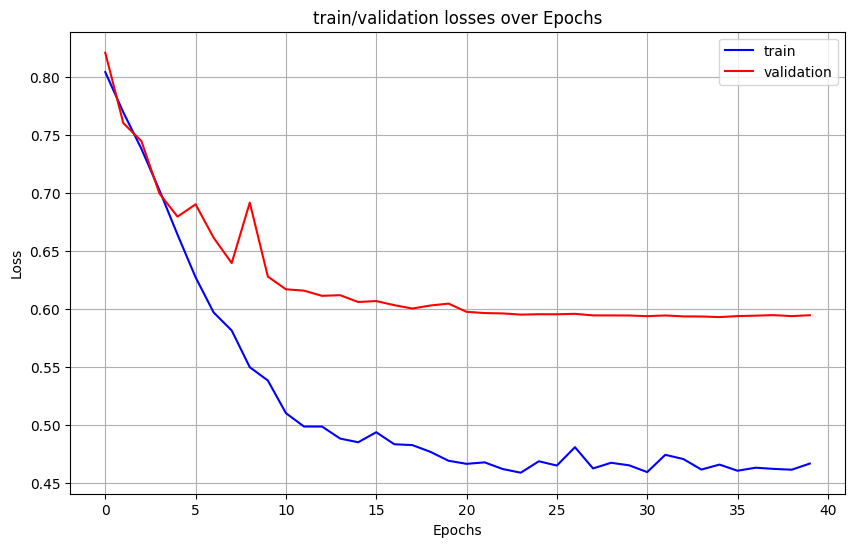

UNET(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=

In [13]:
epochs = list(range(1,len(trainLoss_list)+1))

# Plotting
plt.figure(figsize=(10, 6))

# Plot the first set of accuracies
#for i in range(len(epochs)):
#    plt.plot(epochs[i], trainLoss_list[i], valLoss_list[i], color = 'r')1
plt.plot(trainLoss_list, color = 'blue')
plt.plot(valLoss_list, color = 'red')


# Setting title, labels, and other configurations
plt.title('train/validation losses over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])
plt.grid(True)

# Display the plot
plt.show()

# Free model from GPU Ram
model.to(torch.device("cpu"))

In [55]:
train_dataset=ImageDataset(input_dir=segmentation_data_dir, op="train", mask_json_path=mask_json, transforms=img_transform)
validation_dataset=ImageDataset(input_dir=segmentation_data_dir, op="val", mask_json_path=mask_json, transforms=img_transform)
test_dataset=ImageDataset(input_dir=segmentation_data_dir, op="test", mask_json_path=mask_json, transforms=tensor_transform)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [69]:
## Initialize your unet
n_classes = 6
model_2 = UNET(n_classes)
model_2.to(device)
early_stopper = EarlyStopper(patience=5, min_delta=0)
num_epochs = 200
## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model_2.parameters(),lr=learning_rate)
criterion = DICELoss(num_classes=n_classes)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
trainLoss = []
valLoss = []
print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section

    model_2.train()
    running_loss = 0.0

    for input, label in train_dataloader:
        input = input.cuda()
        label = label.cuda()

        optimizer.zero_grad()
        
        output = model_2(input)
        loss = criterion(output, label)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        input = input.cpu()
        label = label.cpu()
    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(train_dataloader)}")
    trainLoss.append(running_loss/len(train_dataloader))
        
    model_2.eval()
    val_loss = 0.0
    with torch.no_grad():
        for input, label in validation_dataloader:
            input = input.cuda()
            label = label.cuda()

            output = model_2(input)
            val_loss += criterion(output, label).item()

            input = input.cpu()
            label = label.cpu()

    val_loss /= len(validation_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_loss}")
    valLoss.append(val_loss)
    if early_stopper.early_stop(val_loss): 
        break

with torch.no_grad():
    test_dice_score = dice_score_dataset(model_2, test_dataloader, n_classes)
    print(f"Test Dice Score: {test_dice_score}")

Start Training...

EPOCH 1 of 200



OutOfMemoryError: CUDA out of memory. Tried to allocate 50.00 MiB. GPU 0 has a total capacty of 7.92 GiB of which 71.94 MiB is free. Including non-PyTorch memory, this process has 7.25 GiB memory in use. Of the allocated memory 6.92 GiB is allocated by PyTorch, and 210.96 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

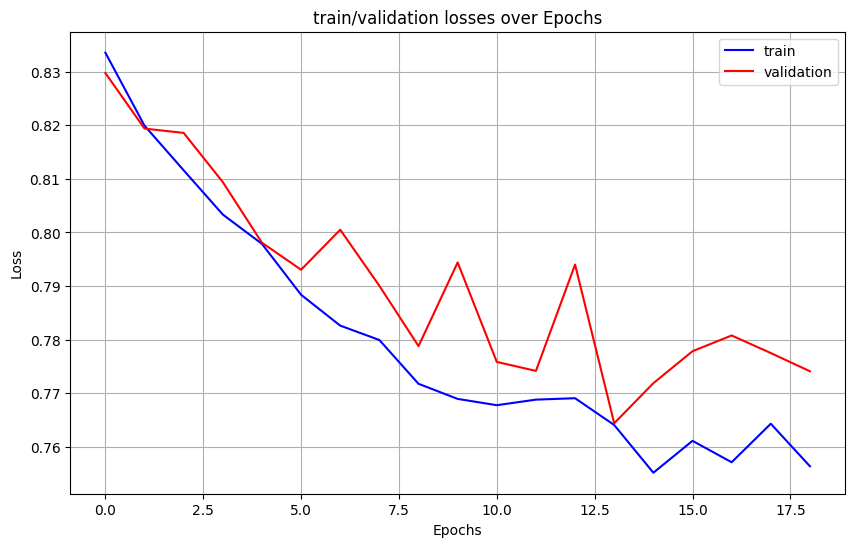

UNET(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=

In [57]:
epochs = list(range(1,len(trainLoss)+1))

# Plotting
plt.figure(figsize=(10, 6))

# Plot the first set of accuracies
#for i in range(len(epochs)):
#    plt.plot(epochs[i], trainLoss_list[i], valLoss_list[i], color = 'r')1
plt.plot(trainLoss, color = 'blue')
plt.plot(valLoss, color = 'red')


# Setting title, labels, and other configurations
plt.title('train/validation losses over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])
plt.grid(True)

# Display the plot
plt.show()

# Free model from GPU Ram
model_2.to(torch.device("cpu"))

## Training Procedure: Colorization Pre-training

Complete the rest of this problem in the cells below.

In [38]:
col_train_dataset=ImageDataset(input_dir=colorization_data_dir, op="train_cor", mask_json_path=mask_json, transforms=tensor_transform)
col_validation_dataset=ImageDataset(input_dir=colorization_data_dir, op="val_cor", mask_json_path=mask_json, transforms=tensor_transform)

col_train_dataloader = DataLoader(col_train_dataset, batch_size=train_batch_size, shuffle=True)
col_validation_dataloader = DataLoader(col_validation_dataset, batch_size=validation_batch_size, shuffle=False)

Start Training...

EPOCH 1 of 200

Epoch 1/200 - Loss: 0.008281599704627206
Epoch 1/200 - Validation Loss: 0.002454111725091934

EPOCH 2 of 200

Epoch 2/200 - Loss: 0.0014835230555127626
Epoch 2/200 - Validation Loss: 0.0024739339482039214

EPOCH 3 of 200

Epoch 3/200 - Loss: 0.0014000575299046745
Epoch 3/200 - Validation Loss: 0.0021152552450075745

EPOCH 4 of 200

Epoch 4/200 - Loss: 0.0011658743569340393
Epoch 4/200 - Validation Loss: 0.0019464907236397266

EPOCH 5 of 200

Epoch 5/200 - Loss: 0.001084443219826094
Epoch 5/200 - Validation Loss: 0.0021475313231348993

EPOCH 6 of 200

Epoch 6/200 - Loss: 0.000993014808594829
Epoch 6/200 - Validation Loss: 0.002946252888068557

EPOCH 7 of 200

Epoch 7/200 - Loss: 0.0009482749884233535
Epoch 7/200 - Validation Loss: 0.0021921983920037747

EPOCH 8 of 200

Epoch 8/200 - Loss: 0.0009053823045372916
Epoch 8/200 - Validation Loss: 0.003828984405845404

EPOCH 9 of 200

Epoch 9/200 - Loss: 0.0008633271274859753
Epoch 9/200 - Validation Loss: 0.

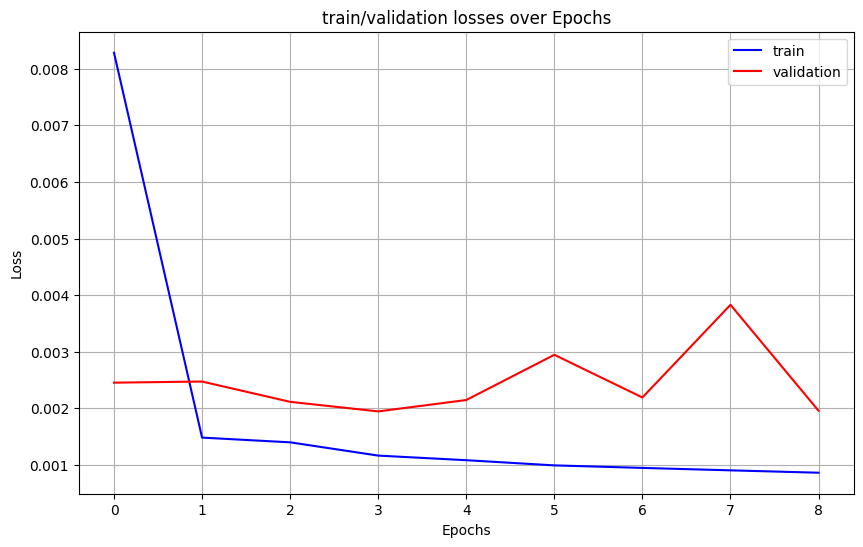

In [39]:
## Initialize your unet
n_classes = 6
model_col = UNET(n_classes, useBN=True)
model_col.out_conv = nn.Conv2d(32, 3, kernel_size=1) # change the last layer to RBG guessing
model_col.to(device)
early_stopper = EarlyStopper(patience=5)
## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model_col.parameters(),lr=learning_rate)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
trainLoss = []
valLoss = []
print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section

    model_col.train()
    running_loss = 0.0

    for input, label in col_train_dataloader:
        input = input.cuda()
        label = label.cuda()
        
        optimizer.zero_grad()
        
        output = model_col(input)
        
        #print("outputs: ", outputs.size())
        loss = criterion(output, label)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        input = input.cpu()
        label = label.cpu()
    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(col_train_dataloader)}")
    trainLoss.append(running_loss/len(col_train_dataloader))
        
    model_col.eval()
    val_loss = 0.0
    with torch.no_grad():
        for input, label in col_validation_dataloader:
            input = input.cuda()
            label = label.cuda()

            output = model_col(input)
            val_loss += criterion(output, label).item()

            input = input.cpu()
            label = label.cpu()

    val_loss /= len(col_validation_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_loss}")
    valLoss.append(val_loss)
    if early_stopper.early_stop(val_loss): 
        break

epochs = list(range(1,len(trainLoss)+1))
# Plotting
plt.figure(figsize=(10, 6))

# Plot the first set of accuracies
#for i in range(len(epochs)):
#    plt.plot(epochs[i], trainLoss_list[i], valLoss_list[i], color = 'r')1
plt.plot(trainLoss, color = 'blue')
plt.plot(valLoss, color = 'red')


# Setting title, labels, and other configurations
plt.title('train/validation losses over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])
plt.grid(True)

# Display the plot
plt.show()

In [58]:
# Initial the dataset
train_dataset=ImageDataset(input_dir=segmentation_data_dir, op="train", mask_json_path=mask_json, transforms=tensor_transform)
validation_dataset=ImageDataset(input_dir=segmentation_data_dir, op="val", mask_json_path=mask_json, transforms=tensor_transform)
test_dataset=ImageDataset(input_dir=segmentation_data_dir, op="test", mask_json_path=mask_json, transforms=tensor_transform)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Start Training...

EPOCH 1 of 200

Epoch 1/200 - Loss: 0.8456821699937185
Epoch 1/200 - Validation Loss: 0.8401915073394776

EPOCH 2 of 200

Epoch 2/200 - Loss: 0.8356483777364095
Epoch 2/200 - Validation Loss: 0.8314552664756775

EPOCH 3 of 200

Epoch 3/200 - Loss: 0.8279973685741424
Epoch 3/200 - Validation Loss: 0.8246599197387695

EPOCH 4 of 200

Epoch 4/200 - Loss: 0.8217130760351817
Epoch 4/200 - Validation Loss: 0.819414746761322

EPOCH 5 of 200

Epoch 5/200 - Loss: 0.8167700787385305
Epoch 5/200 - Validation Loss: 0.8144633293151855

EPOCH 6 of 200

Epoch 6/200 - Loss: 0.8123245616753896
Epoch 6/200 - Validation Loss: 0.8106683969497681

EPOCH 7 of 200

Epoch 7/200 - Loss: 0.808614440759023
Epoch 7/200 - Validation Loss: 0.8071464776992798

EPOCH 8 of 200

Epoch 8/200 - Loss: 0.8047246932983398
Epoch 8/200 - Validation Loss: 0.8037050604820252

EPOCH 9 of 200

Epoch 9/200 - Loss: 0.8009874244530996
Epoch 9/200 - Validation Loss: 0.8003459811210633

EPOCH 10 of 200

Epoch 10/200

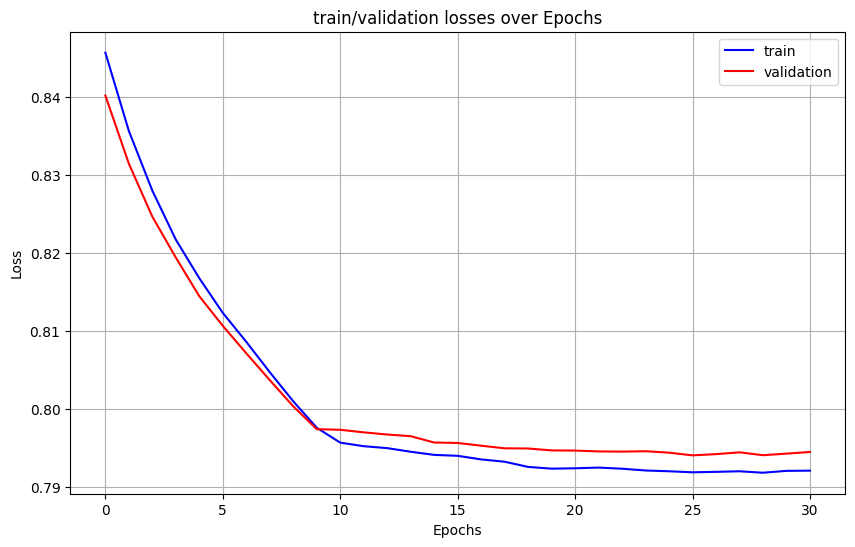

UNET(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=

In [61]:
# Freeze the weights of the UNet
for param in model_col.parameters():
    param.requires_grad = False

# Change the last layer of the model back to guessing 6 classes
model_col.out_conv = nn.Conv2d(32, n_classes, kernel_size=1)
model_col.to(device)
early_stopper = EarlyStopper(patience=5)

## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model_col.out_conv.parameters(),lr=learning_rate)
criterion = DICELoss(num_classes=n_classes)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

trainLoss = []
valLoss = []
print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section

    model_col.train()
    train_loss = 0.0

    for input, label in train_dataloader:
        input = input.cuda()
        label = label.cuda()

        optimizer.zero_grad()
        
        output = model_col(input)
        loss = criterion(output, label)
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        input = input.cpu()
        label = label.cpu()

    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss/len(train_dataloader)}")
    trainLoss.append(train_loss/len(train_dataloader))
        
    model_col.eval()
    val_loss = 0.0
    with torch.no_grad():
        for input, label in validation_dataloader:
            input = input.cuda()
            label = label.cuda()

            output = model_col(input)
            val_loss += criterion(output, label).item()

            input = input.cpu()
            label = label.cpu()

    val_loss /= len(validation_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_loss}")
    valLoss.append(val_loss)

    if early_stopper.early_stop(val_loss): 
        break

with torch.no_grad():
    test_dice_score = dice_score_dataset(model_col, test_dataloader, n_classes)
    print(f"Test Dice Score: {test_dice_score}")

epochs = list(range(1,len(trainLoss)+1))

# Plotting
plt.figure(figsize=(10, 6))

# Plot the first set of accuracies
#for i in range(len(epochs)):
#    plt.plot(epochs[i], trainLoss_list[i], valLoss_list[i], color = 'r')1
plt.plot(trainLoss, color = 'blue')
plt.plot(valLoss, color = 'red')


# Setting title, labels, and other configurations
plt.title('train/validation losses over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])
plt.grid(True)

# Display the plot
plt.show()

# Free model from GPU Ram
model_col.to(torch.device("cpu"))

# Problem 2: Transfer Learning

### Imports

In [1]:
## Import VGG and FashionMNIST
from torchvision.models import vgg16
from torchvision.datasets import FashionMNIST

### Data Loading

In [4]:
## Specify Batch Size
train_batch_size = 32
test_batch_size = 32

## Specify Image Transforms
img_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## Download Datasets
train_data = FashionMNIST('./data', transform=img_transform, download=True, train=True)
test_data = FashionMNIST('./data', transform=img_transform, download=True, train=False)

## Initialize Dataloaders
training_dataloader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=test_batch_size, shuffle=True)

NameError: name 'test_dataset' is not defined

### Model Initialization and Training/Fine-tuning

Complete the rest of the assignment in the notebook below.

In [63]:
vgg16_clone = vgg16(weights = None) # randomly initialize
vgg16_clone.classifier[6] = nn.Linear(vgg16_clone.classifier[6].in_features, 10) # change the last layer to 10 classes
vgg16_clone.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [65]:
# Define loss func and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg16_clone.parameters(), lr=0.01, momentum=0.9)

In [68]:
# Train the model
vgg16_clone.train()
for epoch in range(5):
    running_loss = 0.0
    for input, label in training_dataloader:
        input = input.cuda()
        label = label.cuda()

        optimizer.zero_grad()
        
        output = vgg16_clone(input)
        loss = criterion(output, label)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        input = input.cpu()
        label = label.cpu()
    
    print(f"EPOCH {epoch+1} - Loss: {running_loss/len(training_dataloader)}")

# Evaluate the model
correct = 0
total = 0
with torch.no_grad():
    vgg16.eval()
    for input, label in test_dataloader:
        input = input.cuda()
        label = label.cuda()

        output = vgg16_clone(input)
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

        input = input.cpu()
        label = label.cpu()

print(f"Accuracy of the VGG16 model on test images: {100 * correct / total}%")

# Free model from GPU Ram
vgg16_clone.to(torch.device("cpu"))

OutOfMemoryError: CUDA out of memory. Tried to allocate 392.00 MiB. GPU 0 has a total capacty of 7.92 GiB of which 217.25 MiB is free. Including non-PyTorch memory, this process has 7.10 GiB memory in use. Of the allocated memory 6.61 GiB is allocated by PyTorch, and 369.43 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
vgg16_pre = vgg16(pretrained = True)

# Freeze the parameters in vgg16_pre
for param in vgg16_pre.parameters():
    param.requires_grad = False

vgg16_pre.classifier[6] = nn.Linear(vgg16_pre.classifier[6].in_features, 10)
optimizer = torch.optim.SGD(vgg16_pre.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

vgg16_pre.to(device)

In [ ]:
# Train the model
vgg16_pre.train()
for epoch in range(5):
    running_loss = 0
    for input, label in training_dataloader:
        input = input.cuda()
        label = label.cuda()

        optimizer.zero_grad()
        
        output = vgg16_pre(input)
        loss = criterion(output, label)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        input = input.cpu()
        label = label.cpu()
    
    print(f"Epoch {epoch+1} - Loss: {running_loss/len(training_dataloader)}")

# Evaluate the model
vgg16_pre.eval()
correct = 0
total = 0
with torch.no_grad():
    for input, label in test_dataloader:
        input = input.cuda()
        label = label.cuda()

        output = vgg16_pre(input)
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

        input = input.cpu()
        label = label.cpu()

print(f"Accuracy of the VGG16 model on test images: {100 * correct / total}%")